In [1]:
import torchvision.transforms as transforms
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from zeno import load_data, load_model, metric

In [2]:
transform_image = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



classes = (
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


@load_model
def load_model(model_path):
    net = Net()
    net.load_state_dict(torch.load(model_path))
    print(net)
    
    visualisation = {}

    def hook_fn(m, i, o):
        visualisation[m] = o 

    def get_all_layers(net):
        for name, layer in net._modules.items():
            #If it is a sequential, don't register a hook on it
            # but recursively register hook on all it's module children
            if isinstance(layer, nn.Sequential):
                get_all_layers(layer)
            else:
                # it's a non sequential. Register a hook
                layer.register_forward_hook(hook_fn)

    get_all_layers(net)

    df_metadata = open("../extract_subsets_10_10_10/data.csv", "r")
    data_path = "../extract_subsets_10_10_10"
    instances = [PIL.Image.open(os.path.join(data_path, img)) for img in df_metadata.index]

    imgs = torch.stack([transform_image(img) for img in instances])
    with torch.no_grad():
        out = net(imgs)
    return visualisation.keys()
    
    return [classes[i] for i in torch.argmax(out, dim=1).detach().numpy()]

    # def pred(instances):
    #     imgs = torch.stack([transform_image(img) for img in instances])
    #     with torch.no_grad():
    #         out = net(imgs)
    #     #h.remove()
    #     return [classes[i] for i in torch.argmax(out, dim=1).detach().numpy()]
    # return pred

    # Just to check whether we got all layers

@load_data
def load_data(df_metadata, data_path):
    return [PIL.Image.open(os.path.join(data_path, img)) for img in df_metadata.index]


In [4]:
cd ../..

__pycache__/            class.py
breast_cancer_tests.py  test.ipynb


In [3]:
load_model("cifar/cifar_net_1.pth")

FileNotFoundError: [Errno 2] No such file or directory: 'cifar/cifar_net_1.pth'

In [1]:
import torchvision.transforms as transforms
import PIL
import torch
import os
from zeno import load_data, load_model, metric
from examples.breast_cancer.vgg_old import vgg16_bn
import torch.nn as nn
import torch.nn.functional as F

transform_image = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

classes = (
    "normal",
    "lesion"
)


num_classes = 2
image_res = 512
transform_image = transforms.Compose(
    [transforms.Resize(image_res), transforms.ToTensor(),
])


@load_model
def load_model(model_path):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = vgg16_bn(pretrained=False)
    model.classifier.fc8a = nn.Linear(model.classifier.fc8a.in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    print(model)
    def pred(instances):
        imgs = torch.stack([transform_image(img) for img in instances], dim=0)
        
        with torch.no_grad():
            out = model(imgs)
            prob = F.softmax(out, dim=1)
        return [classes[i] for i in torch.argmax(prob, dim=1).detach().numpy()]

    return pred


@load_data
def load_data(df_metadata, data_path):
    return [PIL.Image.open(os.path.join(data_path, img)) for img in df_metadata.index]



In [2]:
load_model("../best_model.pth")

VGG(
  (features): Sequential(
    (conv1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn1_1): ReLU(inplace=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn1_2): ReLU(inplace=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2_1): ReLU(inplace=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2_2): ReLU(inplace=True)
    (pool2): MaxPool2d(kernel_size=2, stride=

<function __main__.load_model.<locals>.pred(instances)>

In [1]:
import torchvision.transforms as transforms
import PIL
import torch
import os
from zeno import load_data, load_model, metric
from examples.breast_cancer.vgg_old import vgg16_bn
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
transform_image = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

classes = (
    "normal",
    "lesion"
)


num_classes = 2
image_res = 512
transform_image = transforms.Compose(
    [transforms.Resize(image_res), transforms.ToTensor(),
])


@load_model
def load_model(model_path):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = vgg16_bn(pretrained=False)
    model.classifier.fc8a = nn.Linear(model.classifier.fc8a.in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    
    visualisation = {}

    def hook_fn(m, i, o):
        visualisation[m] = o 

    def get_all_layers(net):
        for name, layer in net._modules.items():
            #If it is a sequential, don't register a hook on it
            # but recursively register hook on all it's module children
            if isinstance(layer, nn.Sequential):
                get_all_layers(layer)
            else:
                # it's a non sequential. Register a hook
                layer.register_forward_hook(hook_fn)

    get_all_layers(model)

    df_metadata = pd.read_csv("../extract_subsets_10_10_10/data.csv")
    data_path = "../extract_subsets_10_10_10"
    instances = [PIL.Image.open(os.path.join(data_path, img)) for img in df_metadata.patch_dir]

    imgs = torch.stack([transform_image(img) for img in instances])
    with torch.no_grad():
        out = model(imgs)
    print(out)
    return visualisation.keys()
    

@load_data
def load_data(df_metadata, data_path):
    return [PIL.Image.open(os.path.join(data_path, img)) for img in df_metadata.index]



In [1]:
import torchvision.transforms as transforms
import PIL
import torch
import os
from zeno import load_data, load_model, metric
from examples.breast_cancer.vgg_old import vgg16_bn
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
transform_image = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

classes = (
    "normal",
    "lesion"
)


num_classes = 2
image_res = 512
transform_image = transforms.Compose(
    [transforms.Resize(image_res), transforms.ToTensor(),
])


@load_model
def load_model(model_path):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = vgg16_bn(pretrained=False)
    model.classifier.fc8a = nn.Linear(model.classifier.fc8a.in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    
    # a dict to store the activations
    activation = {}
    def getActivation(name):
        # the hook signature
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # register forward hooks on the layers of choice
    h = model.classifier.relu7.register_forward_hook(getActivation('emb'))
    # h2 = model.classifier.drop7.register_forward_hook(getActivation('drop'))
    
    df_metadata = pd.read_csv("../extract_subsets_10_10_10_2/data_2.csv")
    data_path = "../extract_subsets_10_10_10_2"
    instances = [PIL.Image.open(os.path.join(data_path, img)) for img in df_metadata.patch_dir]
    imgs = torch.stack([transform_image(img) for img in instances])

    emb = []
    drop = []
    with torch.no_grad():
        out = model(imgs)
        emb.append(activation['emb'])
        # drop.append(activation['drop'])
        prob = F.softmax(out, dim=1)
    h.remove()
    # h2.remove()
    # print(drop)
    return [classes[i] for i in torch.argmax(prob, dim=1).detach().numpy()], emb[0].detach().numpy()

In [1]:
import torchvision.transforms as transforms
import PIL
import torch
import os
from zeno import load_data, load_model, metric
from examples.breast_cancer.vgg_old import vgg16_bn
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
transform_image = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

classes = (
    "normal",
    "lesion"
)


num_classes = 2
image_res = 512
transform_image = transforms.Compose(
    [transforms.Resize(image_res), transforms.ToTensor(),
])

@load_model
def load_model(model_path):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = vgg16_bn(pretrained=False)
    model.classifier.fc8a = nn.Linear(model.classifier.fc8a.in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    # a dict to store the activations
    activation = {}

    def getActivation(name):
        # the hook signature
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # register forward hooks on the layers of choice
    h = model.classifier.fc7.register_forward_hook(getActivation('emb'))

    df_metadata = pd.read_csv("../extract_subsets_4619_4710_91/dataset.csv")
    data_path = "../extract_subsets_4619_4710_91"
    instances = [PIL.Image.open(os.path.join(data_path, img)) for img in df_metadata.patch_dir]
    imgs = torch.stack([transform_image(img) for img in instances])

    prob = []
    emb = None
    with torch.no_grad():
        for img in imgs:
            out = model(img.unsqueeze(0))
            if emb is None:
                emb = activation['emb']
            else:
                emb = torch.cat((emb, activation['emb']), 0)
            p = F.softmax(out, dim=1)
            index = (torch.argmax(p, dim=1).detach().numpy())[0]
            prob.append(classes[index])
    h.remove()
    return prob, emb.detach().numpy()

In [10]:
from PIL import Image, ImageStat
def get_brightness(im):
    im_grey = im.convert("LA")
    width, height = im.size

    total = 0
    for i in range(0, width):
        for j in range(0, height):
            total += im_grey.getpixel((i, j))[0]

    return total / (width * height)
def brightness(im):
   im = im.convert('L')
   stat = ImageStat.Stat(im)
   return stat.mean[0]
im = Image.open("../extract_subsets_10_10_10_2/1.5773351999367907638940808079863961894_1571_1471.png")
a = get_brightness(im)
im = "../extract_subsets_10_10_10_2/1.5773351999367907638940808079863961894_1571_1471.png"
b = brightness(im)



77.01866912841797 77.01866912841797 True


In [2]:
a = load_model("../best_model.pth")


In [4]:
embedding = a[1]

In [5]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
import umap.plot

In [6]:
embed_mapper = umap.UMAP().fit(embedding)

In [30]:
from pandas import *
 
# reading CSV file
data = read_csv("../extract_subsets_4619_4710_91/dataset.csv")
 
# converting column data to list
true_labels = np.array(data['label'].tolist())

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<AxesSubplot:>

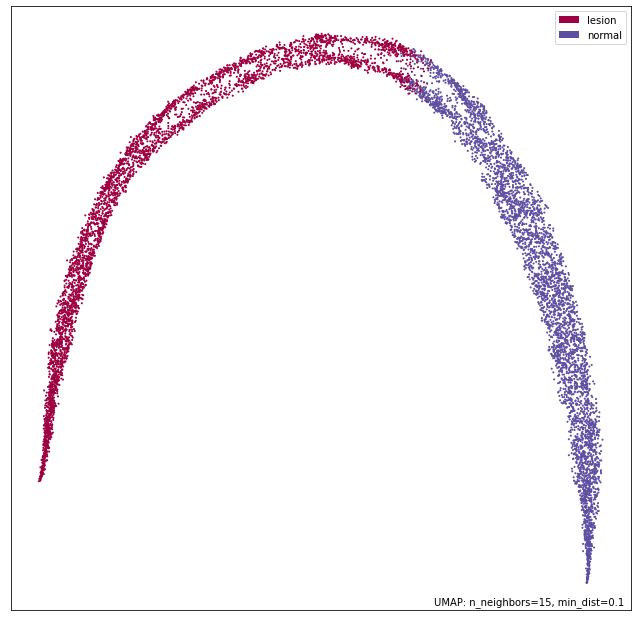

In [32]:
umap.plot.points(embed_mapper, labels=np.array(a[0]))

<AxesSubplot:>

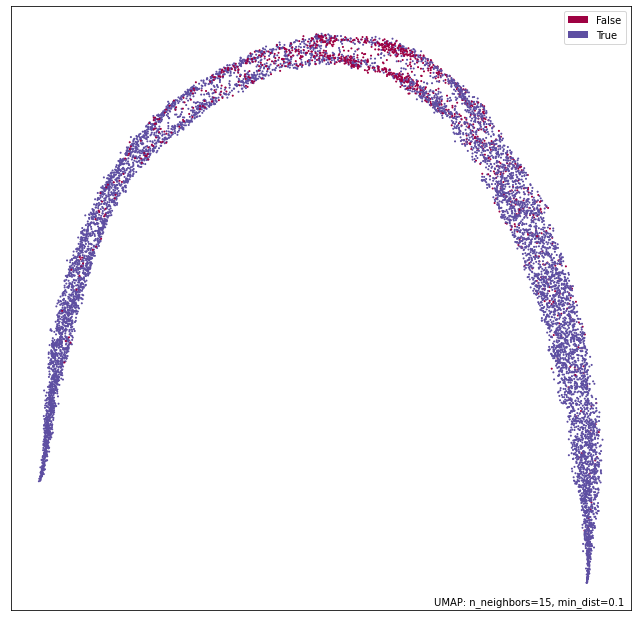

In [31]:
umap.plot.points(embed_mapper, labels=(np.array(a[0] == true_labels)))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

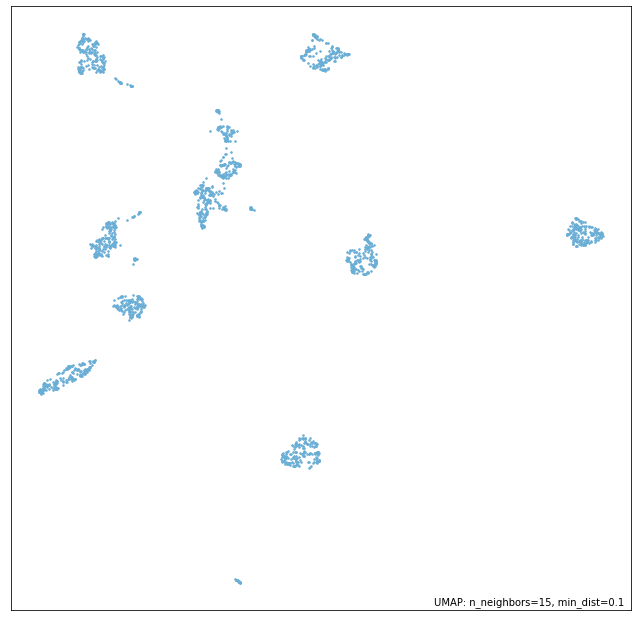

In [7]:
pendigits = sklearn.datasets.load_digits()
mapper = umap.UMAP().fit(pendigits.data)
umap.plot.points(mapper)

In [2]:
load_model("../best_model.pth")

[tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.5222e-02, 1.9532e-01, 0.0000e+00, 1.3191e-01,
         0.0000e+00, 8.0162e-02, 3.1197e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         5.2148e-01, 2.4213e-02, 5.0010e-01, 1.4385e-01, 6.3102e-01, 0.0000e+00,
         0.0000e+00, 2.9099e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0531e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7633e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3900e-01,
         1.2327e-01, 0.0000e+00, 0.0000e+00, 6.7161e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 7.7500e-02, 0.0000e+00, 8.7439e-03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.9490e-01, 0.0000

[]

In [8]:
import csv
import json
 
 
# Function to convert a CSV to JSON
# Takes the file paths as arguments
def make_json(csvFilePath, jsonFilePath):
     
    # create a dictionary
    data = []
     
    # Open a csv reader called DictReader
    with open(csvFilePath, encoding='utf-8') as csvf:
        csvReader = csv.DictReader(csvf)
         
        # Convert each row into a dictionary
        # and add it to data
        for rows in csvReader:
             
            # Assuming a column named 'No' to
            # be the primary key
            # key = rows['']
            data.append(rows)
 
    # Open a json writer, and use the json.dumps()
    # function to dump data
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf:
        jsonf.write(json.dumps(data, indent=4))
         
# Driver Code
 
# Decide the two file paths according to your
# computer system
csvFilePath = r'breast_cancer/data.csv'
jsonFilePath = r'test.json'
 
# Call the make_json function
make_json(csvFilePath, jsonFilePath)

In [11]:
test_data = "test.json"
import numpy as np
with open(test_data, 'r') as f:
    all_test_data = json.load(f)
# print(all_test_data)
full_img = np.array(PIL.Image.open(all_test_data[0]['imaging_dir']))
full_img.shape

FileNotFoundError: [Errno 2] No such file or directory: './patch/version_0/lesion_512/Patient_4222609419/L_MLO/1.135365287044223789913826196762630812825.png'

In [1]:
from models.breast_cancer.vgg_old import vgg16_bn
# from skimage.util import view_as_blocks
import math
import numpy as np
# import cv2
import torchvision.transforms as transforms
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from zeno import load_data, load_model, metric

num_classes = 2
image_res = 512
transform_image = transforms.Compose(
    [transforms.Resize(image_res), transforms.ToTensor(),
])

@load_model
def load_model(model_path):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = vgg16_bn(pretrained=False)
    model.classifier.fc8a = nn.Linear(model.classifier.fc8a.in_features, num_classes)
    model.load_state_dict(torch.load("models/breast_cancer/best_model.pth", map_location=torch.device('cpu')))

    def pred(instances):
        imgs = torch.stack([transform_image(img) for img in instances], dim = 0)
        with torch.no_grad():
            out = model(imgs)
            prob = F.softmax(out, dim=1)
        return [classes[i] for i in torch.argmax(prob, dim = 1).detach().numpy()]

    return pred

@load_data
def load_data(df_metadata, data_path):
    return [PIL.Image.open(os.path.join(data_path, img)) for img in df_metadata.patch_dir]


# def pad_img(img, patch_size, stride):
#     h, w = img.shape
    
#     desired_h = math.ceil( (h - patch_size) / stride ) * stride + patch_size
#     desired_w = math.ceil( (w - patch_size) / stride ) * stride + patch_size
    
#     delta_w = desired_w - w
#     delta_h = desired_h - h
    
#     top, bottom = 0, delta_h
#     left, right = 0, delta_w

#     color = [0, 0, 0]
#     img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
#     return img





# data_v = 'version_0'

# test_data = f'./json/{data_v}/test_{image_res}.json'

# with open(test_data, 'r') as f:
#     all_test_data = json.load(f)

# full_img = np.array(PIL.Image.open(all_test_data[0]['imaging_dir']))

# padded_img = pad_img(full_img, image_res, image_res)
# patches = view_as_blocks(padded_img, (image_res, image_res)).squeeze()
# mask = (np.count_nonzero(patches, axis=(2, 3)) / image_res ** 2) > 0.9
# val_inds = np.argwhere(mask > 0)
# val_patches = patches[val_inds[:, 0], val_inds[:, 1], ...]



In [2]:
load_model("models/breast_cancer/best_model.pth")

<function __main__.load_model.<locals>.pred(instances)>